In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM, AutoModelForSequenceClassification
from datasets import load_dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix, binary_f1_score
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd
from huggingface_hub import notebook_login
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict, deque
import random
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
from src.preprocessing.sequence_classification.dataset import get_n_shots_per_class, get_dataloader
from src.model.sequence_classification.trainer import SequenceClassificationTrainer

import re
from typing import List, Dict
    

import warnings
warnings.filterwarnings("ignore")

In [ ]:
notebook_login()

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
!mkdir logs
model_name = "Finetuning"
dataset_name = "RAFT-TWITTER-COMPLAINTS"
logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)
device = "cuda" if torch.cuda.is_available() else "cpu"

mkdir: cannot create directory ‘logs’: File exists


## Get data

In [5]:
twitter_complaints_dataset = load_dataset(
    "ought/raft", 
    name="twitter_complaints" , 
    cache_dir= "/Data/pedro.silva"
)

In [6]:
train_dataset = twitter_complaints_dataset['train'].add_column(
    "labels",
    list(map(lambda x: x- 1, twitter_complaints_dataset['train']['Label']))
)

test_dataset = twitter_complaints_dataset['test'].add_column(
    "labels",
    list(map(lambda x: x- 1, twitter_complaints_dataset['test']['Label']))
)

In [7]:
classes = np.unique(train_dataset['labels'], return_counts=True)
classes

(array([0, 1]), array([17, 33]))

In [8]:
num_classes = len(classes[0])
num_classes

2

In [9]:
train_dataset

Dataset({
    features: ['Tweet text', 'ID', 'Label', 'labels'],
    num_rows: 50
})

In [21]:
classes_names = ["complaint", "no complaint"]

In [12]:
def stratified_train_test_split(
    dataset : Dataset,
    classes : np.ndarray,
    train_size : float
):
    """Performs train test split keeping class distributions

    Args:
        dataset (Dataset): _description_
        classes (np.ndarray): _description_
        train_size (float): _description_

    Returns:
        _type_: _description_
    """    

    indexes_dict = {}
    for label in classes[0]:
        indexes_dict[label] = []

    for i in range(len(dataset['labels'])):
        label = dataset['labels'][i]
        text = dataset['Tweet text'][i]
        indexes_dict[label].append(text)


    train_data = {
        'labels': [],
        'text': []
    }

    validation_data = {
        "labels" : [],
        "text": []
    }

    # generating train data
    for label in classes[0]:
        n = len(indexes_dict[label])
        size = int(train_size * n)

        train_data['text'] += indexes_dict[label][:size]
        train_data['labels'] += [label]*size
        
        validation_data['text'] +=indexes_dict[label][size:]
        validation_data['labels'] += [label]* (n-size)

    return train_data, validation_data

In [13]:
train, val = stratified_train_test_split(
    train_dataset, 
    classes,
    0.6
)

In [14]:
np.bincount(train['labels']), np.bincount(val['labels'])

(array([10, 19]), array([ 7, 14]))

## Train model

In [15]:
class_counts = np.bincount(
    train['labels'],
)

alpha = len(train['labels'])/class_counts

In [16]:
from src.utils import FocalLoss
loss_fn = FocalLoss(
    gamma= 1,
    alpha= alpha,
    device = "cuda"
)

In [17]:
bert = AutoModelForSequenceClassification\
    .from_pretrained(
        "FacebookAI/roberta-large", 
        num_labels = num_classes,
        cache_dir = "/Data/pedro.silva"    
    )\
    .to(device)

tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-large", cache_dir = "/Data/pedro.silva"  )

trainer = SequenceClassificationTrainer(
    bert,
    num_classes
)
n_shots = len(train['text'])

train_dataloader = get_dataloader(
    train['text'],
    train['labels'],
    tokenizer,
    n_shots= n_shots,
    equalize_class= False,
    num_classes= num_classes,
    shuffle = True
)


val_dataloader = get_dataloader(
    val['text'],
    val['labels'],
    tokenizer,
    n_shots = 100,
    num_classes=num_classes,
    equalize_class=False
)


history = trainer.compile(
    train_dataloader,
    val_dataloader,
    loss_fn= loss_fn,
    evaluation_fn= multiclass_f1_score,
    n_epochs=15
)


f1: 0.8571428656578064
tensor([[ 5,  2],
        [ 1, 13]], device='cuda:0')


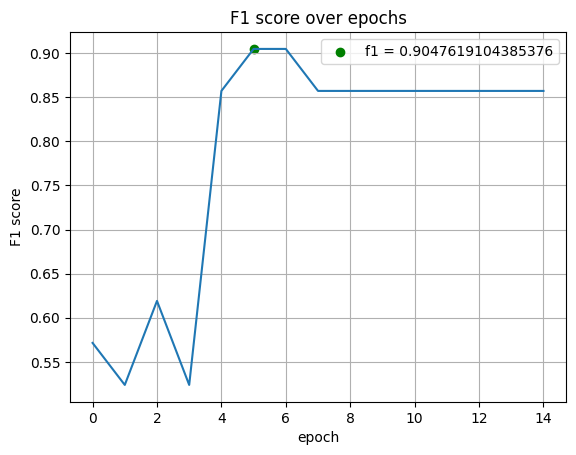

In [27]:
plt.plot(history['val_f1'])
plt.scatter(
    np.argmax(history['val_f1']),
    np.max(history['val_f1']),
    label = f"f1 = {np.max(history['val_f1'])}",
    c = "green"
)

plt.grid()
plt.title("F1 score over epochs")
plt.xlabel("epoch")
plt.ylabel("F1 score")
plt.legend()

Text(0.5, 1.0, 'Confusion Matrix RAFT-TWITTER-COMPLAINTS')

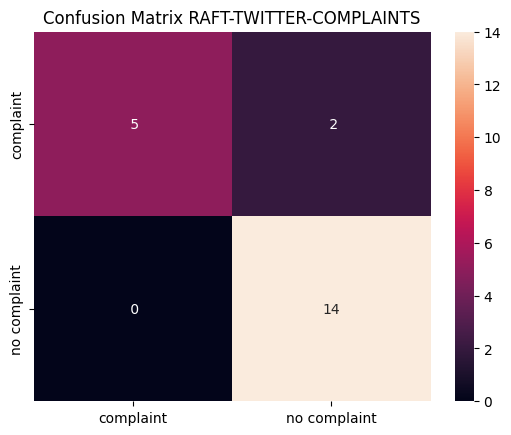

In [22]:
df = pd.DataFrame(
    history['val_conf_matrix'].to("cpu").numpy(),
    index = classes_names,
    columns=classes_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name}")

In [23]:
trainer.best_model.push_to_hub("peulsilva/RoBERTA-large-twitter-complaints")

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/peulsilva/RoBERTA-large-twitter-complaints/commit/051250f1372dfa0bfc02c667a5b74e27cedb0688', commit_message='Upload RobertaForSequenceClassification', commit_description='', oid='051250f1372dfa0bfc02c667a5b74e27cedb0688', pr_url=None, pr_revision=None, pr_num=None)

## Generating submission

In [31]:
model = trainer.best_model
submission = pd.DataFrame()

with torch.no_grad():
    for i in tqdm(range(len(test_dataset))):
        text = test_dataset[i]['Tweet text']
        id = test_dataset[i]['ID']

        tokens = tokenizer(
            text,
            truncation= True,
            padding= "max_length",
            return_tensors= "pt",
            max_length=256,
        )

        for k,v in tokens.items():
            tokens[k] = v.to(device)

        pred = model(**tokens)\
            .logits\
            .argmax()\
            .to('cpu')\
            .item()

        this_row = pd.DataFrame({'ID' : id, "Label": pred}, index = [i])

        submission = pd.concat([submission, this_row],)

  0%|          | 0/3399 [00:00<?, ?it/s]

100%|██████████| 3399/3399 [00:59<00:00, 57.37it/s]


In [32]:
class_label_keymap = { i-1: test_dataset.features['Label'].names[i] for i in range(num_classes +1)} 

In [33]:
class_label_keymap

{-1: 'Unlabeled', 0: 'complaint', 1: 'no complaint'}

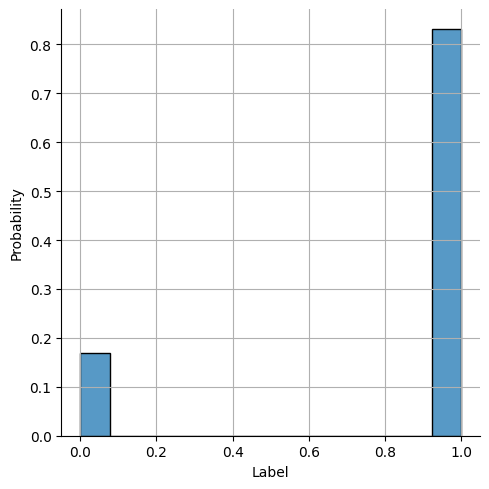

In [46]:
sns.displot(submission['Label'],
            stat = "probability")

plt.grid()

In [47]:
submission

,ID,Label
0,50,1
1,51,1
2,52,1
3,53,1
4,54,1
...,...,...
3394,3444,0
3395,3445,1
3396,3446,1
3397,3447,1


In [48]:
!mkdir submissions/finetuning/twitter_complaints

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [49]:
submission['Label'] = submission['Label'].map(class_label_keymap)

submission.to_csv("submissions/finetuning/twitter_complaints/predictions.csv", index = False)